In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interactive, HBox, VBox
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler as normalizer
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, curdoc
from bokeh.models import Label, Span, VBar, LinearAxis, ColumnDataSource, Plot

output_notebook()
plt.rcParams['figure.figsize'] = [15, 8]
proc_data = "../data/processed/covid/"

Loading BokehJS ...

In [3]:
covid = pd.read_csv(proc_data+"owid-covid-proc.csv", index_col=None, parse_dates=['date'],
                   usecols=['iso_code', 'date', 'new_cases','new_deaths', 'new_tests', 
                            'population', 'total_tests', 'total_cases'])

policy = pd.read_csv(proc_data+"policy_data.csv", index_col='record_id', 
                     dtype={'domestic_policy': bool, 'policy_id': int},
                     parse_dates=['date_announced','date_start','date_end'])

loc = pd.read_csv(proc_data+"allvars_location.csv", index_col='record_id', 
                  usecols=['record_id', 'ISO_A3', 'city', 'province'], dtype={'ISO_A3': str}, na_values={'ISO_A3': '-'})

desc = pd.read_csv(proc_data+"allvars_desc.csv", index_col='policy_id')

policy = policy.join(loc, on='record_id', how='left')

In [4]:
week_grp = pd.Grouper(key="date", freq='W')
norm_covid = covid.groupby(["iso_code", week_grp]).agg({'new_cases': 'sum', 'new_tests': 'sum', 'population':'mean'})

In [5]:
def n(s):
    norm = normalizer()
    return norm.fit_transform(s.values.reshape(-1,1)).flatten()
norm_covid['new_cases'] = norm_covid['new_cases'].groupby(level=0).transform(n)
norm_covid['new_tests'] = norm_covid['new_tests'].groupby(level=0).transform(n)

In [6]:
dm_nt_policy = policy.loc[policy.domestic_policy & (policy.init_country_level=='National')]
plt = figure(plot_width=900, plot_height=600, x_axis_type='datetime')
case_line = plt.line(color='red', legend_label='cases')
tests_line = plt.line(color='blue', legend_label='tests')
start_span = Span(line_color='green', dimension='height')
end_span = Span(line_color='green', dimension='height')
plt.add_layout(start_span)
plt.add_layout(end_span)
plt_hndl = show(plt, notebook_handle=True)

def draw_graph(c, p):
    pol = policy.loc[policy.policy_id==p]
    cvd = norm_covid.loc[c]
    
    start = pol.date_start.dropna().unique()
    if len(start) > 1:
        start = pol.loc[pol.date_start.notna()]
        start = start.loc[start.date_announced.idxmin()].date_start
    elif len(start) == 0:
        start = pol.date_announced.min()
    else:
        start = start[0]
        
    start = pd.Timestamp(start)
    
    end = pol.date_end.dropna().unique()
    
    if len(end) > 1:
        eop = pol.loc[pol.update_type=='End of Policy']
        if len(eop) == 1:
            end = eop[0]
        elif len(eop) > 1:
            end = eop.loc[eop.date_announced.idxmax()].date_end
        else:
            end = pol.loc[pol.date_end.notna()]
            end = end.loc[end.date_announced.idxmax()].date_end
        end = pd.Timestamp(end)
    elif len(end) == 0:
        end = None
    else:
        end = end[0]
        end = pd.Timestamp(end)
        
    l = desc.loc[int(p)].description
    if type(l) is pd.Series:
        l = l.iloc[0]
    desc_box.value = l
    
    case_line.data_source.data.update(y=cvd.new_cases, x=cvd.index)
    tests_line.data_source.data.update(y=cvd.new_tests, x=cvd.index)
    
    start_span.update(location=start)
    end_span.update(location=end)
    
    push_notebook(handle=plt_hndl)
        
def cnt_sel(country):
    pol_w.options=pd.Series(dm_nt_policy.loc[dm_nt_policy.ISO_A3==country].policy_id.unique()).sort_values()
    draw_graph(country, pol_w.value)

def pol_sel(policy):
    draw_graph(cnt_w.value, policy)
    
cnt_w = widgets.Select(options=pd.Series(dm_nt_policy.ISO_A3.dropna().unique()).sort_values())
cnt_i = cnt_w.value
pol_w = widgets.Select(options=pd.Series(dm_nt_policy.loc[dm_nt_policy.ISO_A3==cnt_i].policy_id.unique()).sort_values())

cnt = widgets.interactive(cnt_sel, country=cnt_w)
pol = widgets.interactive(pol_sel, policy=pol_w)

desc_box = widgets.Textarea(disabled=False)
ui = HBox([cnt, pol, desc_box])

display(ui)

In [7]:
total_cases = covid.groupby('iso_code').filter(lambda x: x.population.notna().any() & x.total_cases.notna().any())
total_cases = total_cases.groupby('iso_code').apply(lambda x: x.total_cases.max()/(x.population.max()/10000)).rename('cases')

In [8]:
pt = policy.loc[policy.init_country_level=='National' ,['ISO_A3', 'date_start', 'date_end', 'policy_id', 'type']]

In [9]:
def dt_filter(df):    
    start = np.any(~np.isnan(df.date_start.unique()))
    end = np.any(~np.isnan(df.date_end.unique()))
    return start and end

def td(df):
    start = df.date_start.min()
    end = df.date_end.min()
    return pd.Series(data=end-start, index=['duration'], dtype='timedelta64[D]')

def corr(df):
    df.index = df.index.droplevel(0)    
    c = total_cases.loc[total_cases.index.isin(df.index)].to_frame()
    d = c.merge(df, left_index=True, right_index=True).astype({'duration': 'timedelta64[D]'})
    d = d.corr()
    return d.loc['cases', 'duration']

In [10]:
dp = pt.groupby(['type', 'ISO_A3', 'policy_id']).filter(dt_filter).set_index(['type', 'ISO_A3', 'policy_id'])
dp = dp.groupby(level=[0,1,2]).apply(td).groupby(level=[0,1,2]).filter(lambda x: x >= pd.Timedelta(0, 'days'))
dp = dp.groupby(level=[0,1]).agg('sum')
dp = dp.groupby(level=0).filter(lambda x: len(x)>0)
c = dp.groupby(level=0).agg(corr).rename(columns={'duration': 'Correlation'}).sort_values(by='Correlation').dropna()
c.index.rename('Policy Type', inplace=True)

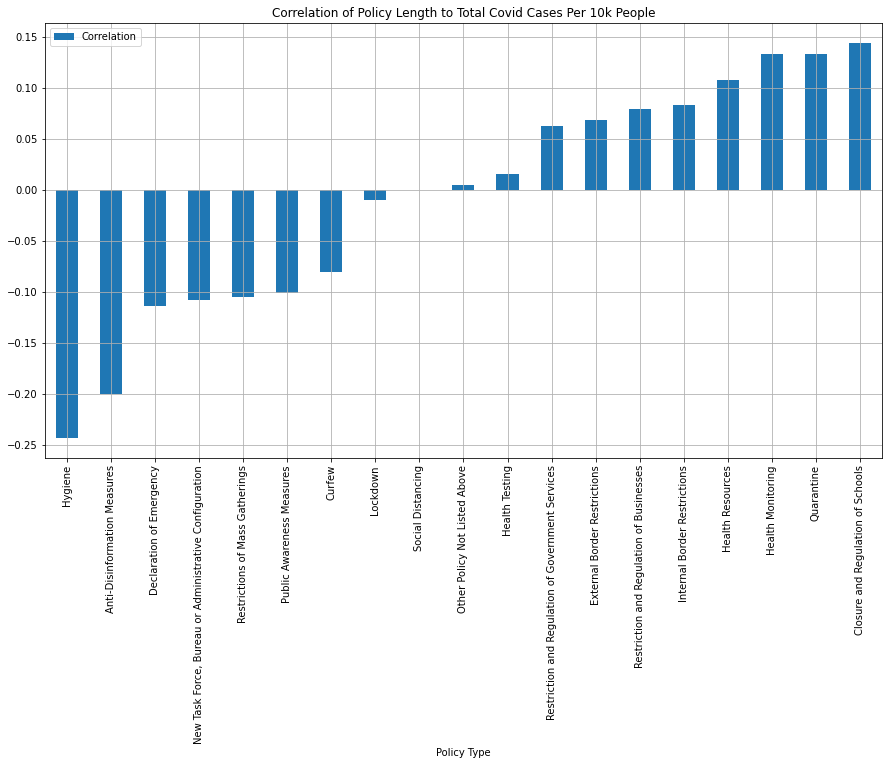

In [11]:
c.plot(kind='bar', title='Correlation of Policy Length to Total Covid Cases Per 10k People', grid=True);

In [21]:
reg_us = pd.read_csv("../data/processed/covid/us_regional_covid.csv", index_col=0,
                     parse_dates=['date'],
                    dtype={'confirmed': np.float64, 'deaths': np.float64, 
                           'recovered': np.float64, 'city': str, 'county': str,
                          'cruise_ship': bool, 'state': str})

In [45]:
us = policy.loc[policy.ISO_A3=='USA']

In [34]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [43]:
tp = us.target_province.transform(lambda x: us_state_abbrev[x] if x in us_state_abbrev else x)

In [50]:
us = us.drop("target_province", axis=1)
us = us.merge(tp, left_index=True, right_index=True)

In [66]:
us = us.loc[us.target_province.isin(reg_us.state.dropna().unique()) & (policy.init_country_level=="Provincial")]
us = us.loc[us.type.notna()]

In [69]:
us

,policy_id,update_type,update_level,date_announced,date_start,date_end,init_country_level,domestic_policy,target_geog_level,target_city,type,type_sub_cat,type_text,school_status,target_direction,ISO_A3,city,province,target_province
record_id,,,,,,,,,,,,,,,,,,,
R_3I9x0DQ8VYXqyIcNA,5268950,NaN,NaN,2020-01-22,2020-01-22,NaT,Provincial,True,A geographical or administrative unit within a...,NaN,Health Monitoring,NaN,NaN,NaN,NaN,USA,NaN,Washington,WA
R_6xmbSctmqkjMA4VAq,4532513,NaN,NaN,2020-01-23,2020-01-23,NaT,Provincial,False,NaN,NaN,Public Awareness Measures,Disseminating information related to COVID-19 ...,NaN,NaN,NaN,USA,NaN,Nebraska,NE
R_1pWiYx7oOo4jIakNA,2300549,NaN,NaN,2020-01-27,2020-01-27,NaT,Provincial,True,NaN,NaN,"New Task Force, Bureau or Administrative Confi...",NaN,NaN,NaN,NaN,USA,NaN,Arizona,AZ
R_3DbxaB5mDE2oq9TNA,116319,NaN,NaN,2020-02-03,2020-02-03,NaT,Provincial,True,NaN,NaN,"New Task Force, Bureau or Administrative Confi...",NaN,NaN,NaN,NaN,USA,NaN,New Jersey,NJ
R_2Rb6aXs9xqCp1sOCe,4318189,NaN,NaN,2020-02-05,2020-02-05,NaT,Provincial,False,NaN,NaN,Health Resources,Other Health Infrastructure,NaN,NaN,NaN,USA,NaN,Wisconsin,WI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_3EW6zZZ4s2BzA4HCu,776202,NaN,NaN,2020-07-09,2020-08-13,2020-08-24,Provincial,True,NaN,NaN,Closure and Regulation of Schools,Primary Schools (generally for children ages 1...,NaN,Primary Schools allowed to open with conditions,NaN,USA,NaN,Arkansas,AR
R_3EW6zZZ4s2BzA4HDp,776202,NaN,NaN,2020-07-09,2020-08-13,2020-08-24,Provincial,True,NaN,NaN,Closure and Regulation of Schools,Secondary Schools (generally for children ages...,NaN,Secondary Schools allowed to open with conditions,NaN,USA,NaN,Arkansas,AR
R_1gdyC25xLGlP5H1Bv,3889409,NaN,NaN,2020-05-29,2024-05-29,2024-05-29,Provincial,True,NaN,NaN,"New Task Force, Bureau or Administrative Confi...",New Task Force or Bureau (i.e. establishment o...,NaN,NaN,NaN,USA,NaN,Michigan,MI


In [97]:
p = us.groupby('policy_id').filter(lambda x: x.date_start.notna().any() & x.date_end.notna().any())
p = p.set_index(['type', 'ISO_A3', 'policy_id'])

In [98]:
p = p.groupby(level=[0, 1, 2]).apply(td)
p = p.groupby(level=[0,1,2]).filter(lambda x: x >= pd.Timedelta(0, 'days'))
p = dp.groupby(level=[0,1]).agg('sum')
p = dp.groupby(level=0).filter(lambda x: len(x)>0)
c = dp.groupby(level=0).agg(corr).rename(columns={'duration': 'Correlation'}).sort_values(by='Correlation').dropna()
c.index.rename('Policy Type', inplace=True)

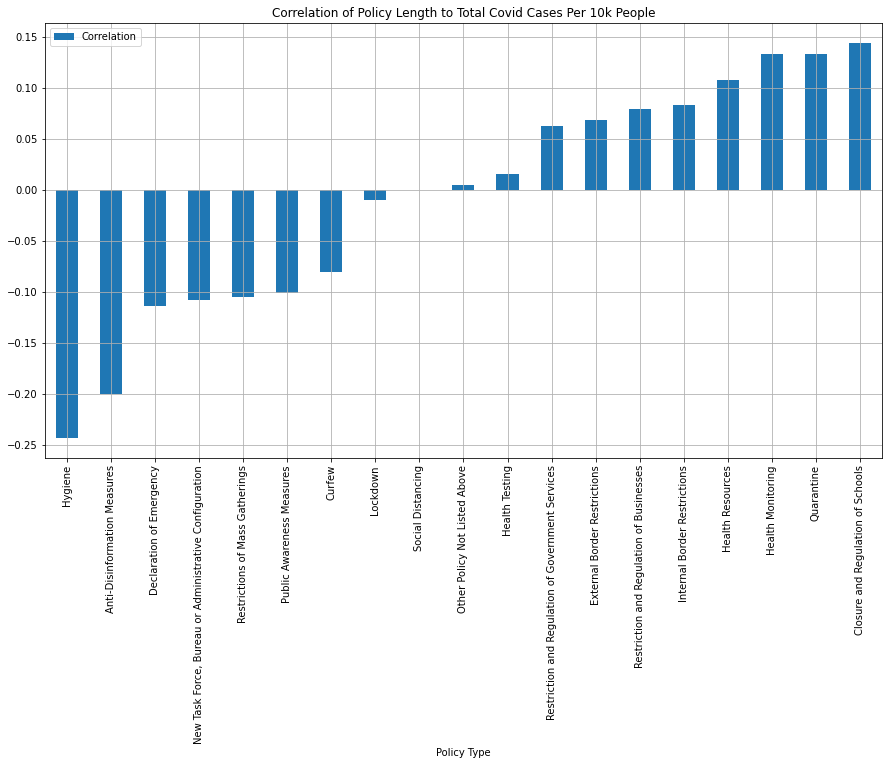

In [99]:
c.plot(kind='bar', title='Correlation of Policy Length to Total Covid Cases Per 10k People', grid=True);